In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

data = Path("../data")
plot_path = data / "plots"

map_path = data / "graph3_map"
geojson_path = map_path / "geojson"
stat_path = map_path / "stats"
country_stat_path = stat_path / "countries"

# Users dataset

In [2]:
users = pd.read_csv(map_path / "user_country.csv")

# 0. Number of users per country

In [3]:
# For each country, count the number of users
country_num_users = (
    users.groupby(["country"])
    .agg({"user_id": "nunique"})
    .reset_index()
    .rename(columns={"user_id": "num_users"})
    .sort_values(by=["num_users", "country"], ascending=[False, True])
)

import numpy as np

num_users_unique = country_num_users["num_users"].unique()
# Add a column "rank" to country_num_users that contains the rank of the country according to the index+1 of num_users in num_users_unique
country_num_users["rank"] = country_num_users["num_users"].apply(
    lambda x: np.where(num_users_unique == x)[0][0] + 1,
)

country_num_users = country_num_users.sort_values(by="country")


country_num_users.to_csv(country_stat_path / "country_num_users.csv", index=False)

OSError: Cannot save file into a non-existent directory: '../data/graph3_map/stats/country'

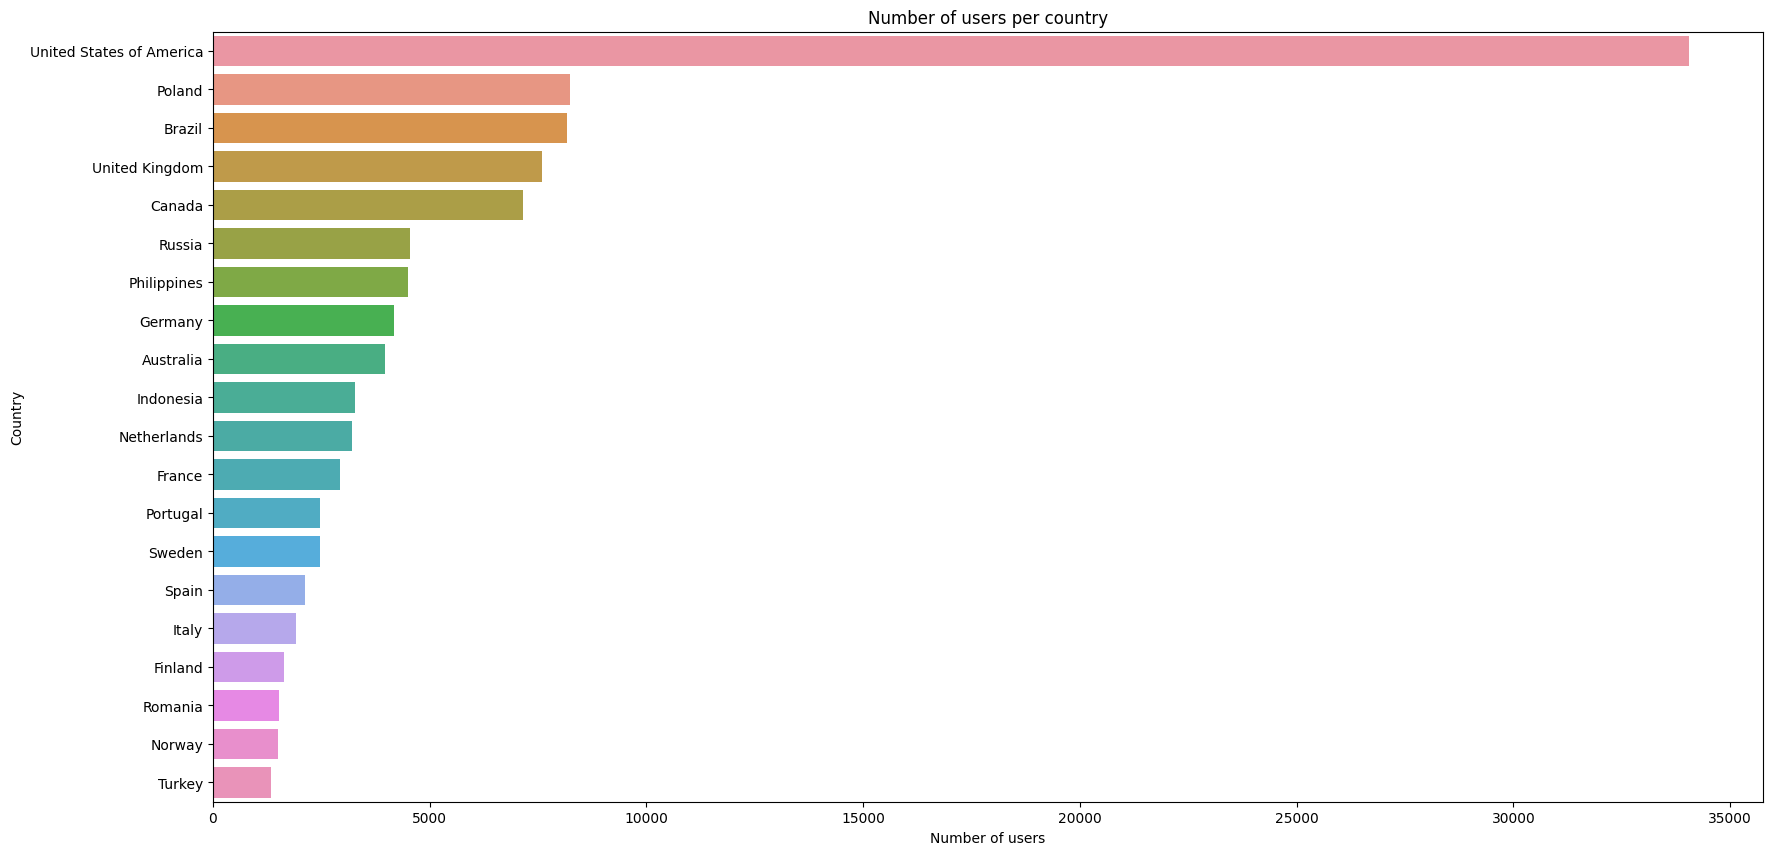

In [ ]:
# histogram of the number of users per country
plt.figure(figsize=(20, 10))
plot = sns.countplot(
    y="country", 
    data=users, 
    order=users["country"].value_counts()[:20].index
)

title = "Number of users per country"
plt.title(title)
plt.xlabel("Number of users")
plt.ylabel("Country")

# Set the background color to white
plot.figure.set_facecolor('white')

plt.show()

# Save the plot as a png file with white background
plot.figure.savefig(plot_path / "country_num_users.png", transparent=False)

# 1. Gender balance per country

In [ ]:
# For each country, derive the gender balance of the users
country_gender_balance = users.groupby(["country"])["gender"].value_counts(normalize=True).unstack().reset_index()
# Replace Nan values by 0
country_gender_balance.fillna(0, inplace=True)

country_gender_balance

gender,country,Female,Male,Non-Binary
0,Afghanistan,0.000000,1.000000,0.000000
1,Albania,0.354839,0.612903,0.032258
2,Algeria,0.210526,0.789474,0.000000
3,Andorra,0.333333,0.666667,0.000000
4,Angola,0.125000,0.875000,0.000000
...,...,...,...,...
199,Venezuela,0.299674,0.700326,0.000000
200,Vietnam,0.225806,0.766129,0.008065
201,Yemen,0.100000,0.900000,0.000000
202,Zambia,0.000000,1.000000,0.000000


In [ ]:
import numpy as np

log3 = lambda x: np.log(x) / np.log(3)

def calculate_entropy(df, columns):
    # Calculate probabilities for each category
    total = df[columns].sum(axis=1)
    probabilities = df[columns].div(total, axis=0)
    
    # Calculate entropy for each row
    entropy = -probabilities.apply(lambda x: np.nansum(x * log3(x)), axis=1)
    
    # Create new dataframe with "entropy" column
    result = df.copy()
    result['entropy'] = entropy
    
    return result

country_gender_balance = calculate_entropy(country_gender_balance, ['Female', 'Male', 'Non-Binary'])
country_gender_balance.sort_values(by="entropy", ascending=False, inplace=True)

unique_entropies = country_gender_balance["entropy"].unique()
# Add a column "rank" to country_gender_balance that contains the rank of the country according to the index+1 of entropy in unique_entropies
country_gender_balance["rank"] = country_gender_balance["entropy"].apply(
    lambda x: np.where(unique_entropies == x)[0][0] + 1,
)

country_gender_balance.sort_values(by="country", inplace=True)


country_gender_balance.to_csv(country_stat_path / "country_gender_balance.csv", index=False)

country_gender_balance

/home/julien/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


gender,country,Female,Male,Non-Binary,entropy,rank
0,Afghanistan,0.000000,1.000000,0.000000,-0.000000,126
1,Albania,0.354839,0.612903,0.032258,0.708589,4
2,Algeria,0.210526,0.789474,0.000000,0.468457,110
3,Andorra,0.333333,0.666667,0.000000,0.579380,68
4,Angola,0.125000,0.875000,0.000000,0.342951,123
...,...,...,...,...,...,...
199,Venezuela,0.299674,0.700326,0.000000,0.555781,88
200,Vietnam,0.225806,0.766129,0.008065,0.527020,97
201,Yemen,0.100000,0.900000,0.000000,0.295903,125
202,Zambia,0.000000,1.000000,0.000000,-0.000000,126


In [ ]:
merge = pd.merge(country_num_users, country_gender_balance, on=["country"])
merge.sort_values(by="entropy", ascending=False)

,country,num_users,rank_x,Female,Male,Non-Binary,entropy,rank_y
157,Saint Vincent and the Grenadines,3,111,0.333333,0.333333,0.333333,1.000000,1
31,Burkina Faso,4,110,0.250000,0.500000,0.250000,0.946395,2
197,Uzbekistan,10,104,0.400000,0.500000,0.100000,0.858673,3
1,Albania,32,93,0.354839,0.612903,0.032258,0.708589,4
29,Brunei,51,85,0.360000,0.620000,0.020000,0.675777,5
...,...,...,...,...,...,...,...,...
96,Kiribati,1,113,0.000000,1.000000,0.000000,-0.000000,126
177,Swaziland,2,112,1.000000,0.000000,0.000000,-0.000000,126
90,Ivory Coast,1,113,1.000000,0.000000,0.000000,-0.000000,126
78,Haiti,3,111,0.000000,1.000000,0.000000,-0.000000,126


# 2. Age slices for each country

Need to load the cleaned dataset, that handled users who have an excessively large or low age

In [ ]:
users["birth_date"].sort_values()

88592        1-01-01
101149    1930-01-01
77418     1930-01-01
84245     1930-01-01
65984     1930-01-01
             ...    
133894           NaN
133897           NaN
133898           NaN
133901           NaN
133902           NaN
Name: birth_date, Length: 133911, dtype: object

In [ ]:
users_cleaned = pd.read_csv(data / "users_cleaned.csv")

# See the differences between the "user_id" set of users_cleaned and the "user_id" set of users
print("Number of users in users_cleaned: {:,}".format(users_cleaned["user_id"].nunique()))
print("Number of users in users: {:,}".format(users["user_id"].nunique()))
print("Number of users in users_cleaned but not in users: {:,}".format(users_cleaned[~users_cleaned["user_id"].isin(users["user_id"])]["user_id"].nunique()))
print("Number of users in users but not in users_cleaned: {:,}".format(users[~users["user_id"].isin(users_cleaned["user_id"])]["user_id"].nunique()))

Number of users in users_cleaned: 108,711
Number of users in users: 133,795
Number of users in users_cleaned but not in users: 11,357
Number of users in users but not in users_cleaned: 36,441


In [ ]:
users_cleaned["birth_date"].sort_values()

108465    1969-01-10 00:00:00
9861      1969-01-11 00:00:00
71624     1969-02-08 00:00:00
16208     1969-02-14 00:00:00
22098     1969-03-05 00:00:00
                 ...         
1718      2008-09-02 00:00:00
3521      2008-09-27 00:00:00
47601     2008-09-28 00:00:00
61694     2008-12-04 00:00:00
9278      2008-12-15 00:00:00
Name: birth_date, Length: 108711, dtype: object

In [ ]:
users_ages = users_cleaned.merge(users, on="user_id", how="inner")
users_ages

,username_x,user_id,user_watching_x,user_completed_x,user_onhold_x,user_dropped_x,user_plantowatch_x,user_days_spent_watching_x,gender_x,location_x,...,gender_y,location_y,birth_date_y,access_rank_y,join_date_y,last_online_y,stats_mean_score_y,stats_rewatched_y,stats_episodes_y,country
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",...,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0,India
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",...,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0,United States of America
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",...,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0,Mexico
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",...,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,920.0,Malaysia
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",...,Male,"Nijmegen, Nederland",1999-10-24,NaN,2015-11-26,1900-05-10 13:53:00,7.86,0.0,1847.0,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97426,isoann,797785,14,213,11,20,136,64.372222,Male,Poland:,...,Male,Poland:,1997-01-13,NaN,2011-10-23,1900-04-02 13:21:00,8.03,2.0,3944.0,Poland
97427,bumcakee,1396285,13,116,5,9,22,41.365972,Female,"nhollywood, california",...,Female,"nhollywood, california",1998-07-18,NaN,2012-07-14,2017-02-14 00:30:00,8.86,24.0,3027.0,United States of America
97428,Scarlet95,2478991,6,103,10,8,54,46.827083,Female,Belgium,...,Female,Belgium,1995-10-17,NaN,2013-04-24,2016-12-18 08:41:00,7.40,1.0,2906.0,Belgium
97429,Torasori,3975907,22,239,0,4,176,72.361111,Male,"Latvia, Riga",...,Male,"Latvia, Riga",1998-11-18,NaN,2014-07-30,2018-05-24 21:34:46,8.98,47.0,5313.0,Latvia


In [ ]:
users_ages["birth_date_x"].sort_values()

97211    1969-01-10 00:00:00
8808     1969-01-11 00:00:00
1066     1969-03-05 00:00:00
10583    1969-03-14 00:00:00
75087    1969-03-20 00:00:00
                ...         
23925    2008-07-16 00:00:00
84475    2008-07-18 00:00:00
3143     2008-09-27 00:00:00
55142    2008-12-04 00:00:00
8285     2008-12-15 00:00:00
Name: birth_date_x, Length: 97431, dtype: object

In [ ]:
users_ages = users_ages[["user_id", "birth_date_x", "country"]]
users_ages.rename(columns={"birth_date_x": "birth_date"}, inplace=True)
# Convert birth_date to the year
users_ages["birth_date"] = pd.to_datetime(users_ages["birth_date"])
users_ages["birth_year"] = users_ages["birth_date"].dt.year

print("Min birth_year: {}".format(users_ages["birth_year"].min()))
print("Max birth_year: {}".format(users_ages["birth_year"].max()))

users_ages

Min birth_year: 1969
Max birth_year: 2008


/tmp/ipykernel_10207/1750739427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_ages.rename(columns={"birth_date_x": "birth_date"}, inplace=True)
/tmp/ipykernel_10207/1750739427.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_ages["birth_date"] = pd.to_datetime(users_ages["birth_date"])
/tmp/ipykernel_10207/1750739427.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,user_id,birth_date,country,birth_year
0,2255153,1990-04-29,India,1990
1,37326,1991-08-01,United States of America,1991
2,228342,1990-12-14,Mexico,1990
3,327311,1998-08-24,Malaysia,1998
4,5015094,1999-10-24,Netherlands,1999
...,...,...,...,...
97426,797785,1997-01-13,Poland,1997
97427,1396285,1998-07-18,United States of America,1998
97428,2478991,1995-10-17,Belgium,1995
97429,3975907,1998-11-18,Latvia,1998


In [ ]:
# Group users by country, and in each country group by birth year
country_users_ages = users_ages.groupby(["country", "birth_year"]).agg({"user_id": "nunique"})
country_users_ages = country_users_ages.rename(columns={"user_id": "num_users"})
country_users_ages

num_users
country  birth_year           
Albania  1989                1
         1991                1
         1992                5
         1993                5
         1994                2
...                        ...
Yemen    2000                1
Zimbabwe 1991                1
         1992                1
         1993                1
         1997                2

[2728 rows x 1 columns]

In [ ]:
country_users_ages.to_csv(country_stat_path / "country_users_ages.csv")

In [ ]:
country_users_ages.loc[["United States of America", "United States of America"]]

num_users
country                  birth_year           
United States of America 1969               23
                         1970               15
                         1971               19
                         1972               20
                         1973               34
...                                        ...
                         2003               60
                         2004               29
                         2005                5
                         2006                5
                         2007                2

[78 rows x 1 columns]

<Figure size 2000x1000 with 0 Axes>

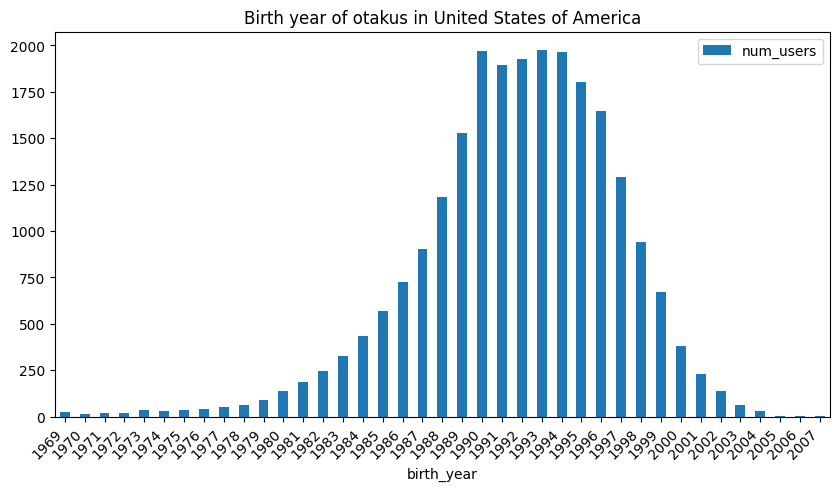

In [ ]:
country = "United States of America"

plt.figure(figsize=(20, 10))
# age_slices.loc[name, :].plot(kind="bar", figsize=(10, 5))

# The previous line does not work anymore, as we have now country as index
country_users_ages.loc[country].plot(kind="bar", figsize=(10, 5))

# Display angled xticks
plt.xticks(rotation=45, ha="right")

plt.title("Birth year of otakus in {}".format(country))
plt.show()

# 3. Average number of days spent watching per country

## Countries where the users watched the highest number of animes

In [ ]:
# group users by country and calculate the average "user_days_spent_watching"
users["user_days_spent_watching"] = users["user_days_spent_watching"].astype(float)
users.groupby("country")["user_days_spent_watching"].mean().sort_values(ascending=False)

country
Argentina                   2837.089936
Solomon Islands              224.930000
Burkina Faso                 213.437500
China                        179.864582
Mozambique                   169.985000
                               ...     
Togo                           8.010000
Anguilla                       4.550000
Marshall Islands               3.670000
Turks and Caicos Islands       0.000000
Senegal                        0.000000
Name: user_days_spent_watching, Length: 204, dtype: float64

Suspicious values: let's look at the cleaned dataset

## Users cleaned dataset

In [ ]:
# Merge but without adding the suffixes
users_days = users_cleaned.merge(users, on="user_id", how="inner")
print("Number of users who have a well-defined number of days spent watching: {:,}".format(users_ages["user_id"].nunique()))
users_days

Number of users who have a well-defined number of days spent watching: 97,354


,username_x,user_id,user_watching_x,user_completed_x,user_onhold_x,user_dropped_x,user_plantowatch_x,user_days_spent_watching_x,gender_x,location_x,...,gender_y,location_y,birth_date_y,access_rank_y,join_date_y,last_online_y,stats_mean_score_y,stats_rewatched_y,stats_episodes_y,country
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",...,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0,India
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",...,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0,United States of America
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",...,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0,Mexico
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",...,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,920.0,Malaysia
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",...,Male,"Nijmegen, Nederland",1999-10-24,NaN,2015-11-26,1900-05-10 13:53:00,7.86,0.0,1847.0,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97426,isoann,797785,14,213,11,20,136,64.372222,Male,Poland:,...,Male,Poland:,1997-01-13,NaN,2011-10-23,1900-04-02 13:21:00,8.03,2.0,3944.0,Poland
97427,bumcakee,1396285,13,116,5,9,22,41.365972,Female,"nhollywood, california",...,Female,"nhollywood, california",1998-07-18,NaN,2012-07-14,2017-02-14 00:30:00,8.86,24.0,3027.0,United States of America
97428,Scarlet95,2478991,6,103,10,8,54,46.827083,Female,Belgium,...,Female,Belgium,1995-10-17,NaN,2013-04-24,2016-12-18 08:41:00,7.40,1.0,2906.0,Belgium
97429,Torasori,3975907,22,239,0,4,176,72.361111,Male,"Latvia, Riga",...,Male,"Latvia, Riga",1998-11-18,NaN,2014-07-30,2018-05-24 21:34:46,8.98,47.0,5313.0,Latvia


In [ ]:
users_days = users_days[["user_id", "user_days_spent_watching_x", "country"]]
users_days = users_days.rename(columns={"user_days_spent_watching_x": "user_days_spent_watching"})
print(users_days["user_days_spent_watching"].describe())
users_days

count    97431.000000
mean        61.935728
std         58.702099
min          0.500694
25%         21.334375
50%         46.404861
75%         84.408333
max        945.683333
Name: user_days_spent_watching, dtype: float64


,user_id,user_days_spent_watching,country
0,2255153,55.091667,India
1,37326,82.574306,United States of America
2,228342,159.483333,Mexico
3,327311,11.394444,Malaysia
4,5015094,30.458333,Netherlands
...,...,...,...
97426,797785,64.372222,Poland
97427,1396285,41.365972,United States of America
97428,2478991,46.827083,Belgium
97429,3975907,72.361111,Latvia


In [ ]:
country_num_days_spent_watching_mean = (
    users_days.groupby(["country"])
    .agg({"user_id": "nunique", "user_days_spent_watching": "mean"})
    .sort_values(by="user_days_spent_watching", ascending=False)
)
country_num_days_spent_watching_mean.columns = ["num_users", "num_days_spent_watching_mean"]

num_days_unique = country_num_days_spent_watching_mean["num_days_spent_watching_mean"].unique()
# Add a column "rank" to studio_num_countries that contains the rank of the studio according to the index+1 of num_countries in num_days_unique
country_num_days_spent_watching_mean["rank"] = country_num_days_spent_watching_mean["num_days_spent_watching_mean"].apply(
    lambda x: np.where(num_days_unique == x)[0][0] + 1,
)

country_num_days_spent_watching_mean = country_num_days_spent_watching_mean.sort_values(by="country")

country_num_days_spent_watching_mean.to_csv(country_stat_path / "country_num_days_spent_watching_mean.csv")
country_num_days_spent_watching_mean

,num_users,num_days_spent_watching_mean,rank
country,,,
Albania,30,62.045010,107
Algeria,78,92.797709,21
Andorra,6,41.127546,172
Angola,7,61.982044,109
Antarctica,25,43.005922,167
...,...,...,...
Vatican,2,81.759242,28
Venezuela,266,73.972497,51
Vietnam,203,51.513756,147


We observe that:
- Argentina is no longer top 1
- A lot of countries have seen their mean decrease
- The countries with mean 0 have been removed 

count    193.000000
mean      66.726980
std       32.308234
min        0.977083
25%       51.989294
50%       63.783953
75%       74.100705
max      216.353472
Name: num_days_spent_watching_mean, dtype: float64


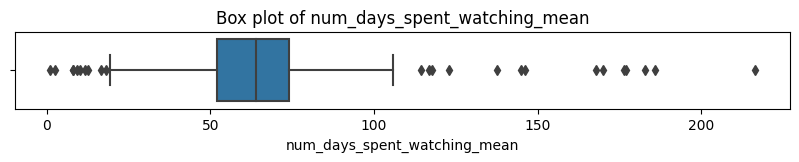

In [ ]:
print(country_num_days_spent_watching_mean["num_days_spent_watching_mean"].describe())

plt.figure(figsize=(10, 1))
plot = sns.boxplot(x="num_days_spent_watching_mean", data=country_num_days_spent_watching_mean)
title = "Box plot of num_days_spent_watching_mean"
plt.title(title)
plt.xlabel("num_days_spent_watching_mean")
plt.show()

Hmm, lots of outliers, even in the cleaned version. Let's look at the corresponding countries

In [ ]:
country_num_days_spent_watching_mean.sort_values(by="num_days_spent_watching_mean", ascending=False)[:20]

,num_users,num_days_spent_watching_mean,rank
country,,,
Solomon Islands,1,216.353472,1
Cameroon,1,186.013426,2
Chad,1,182.938889,3
New Caledonia,1,176.944444,4
Réunion,4,176.478582,5
Kyrgyzstan,1,170.054861,6
Pitcairn Islands,1,168.003472,7
United States Virgin Islands,2,146.014931,8
Mozambique,2,144.828235,9


We observe that the countries with very few users dominate the top.
Let us look only at the countries which count many users (say, more than 1000), to have more representative samples

In [ ]:
country_num_days_spent_watching_mean_100 = country_num_days_spent_watching_mean[country_num_days_spent_watching_mean["num_users"] >= 100]
country_num_days_spent_watching_mean_100.sort_values(by="num_days_spent_watching_mean", ascending=False)[:20]

,num_users,num_days_spent_watching_mean,rank
country,,,
Morocco,117,85.036988,25
Slovenia,107,83.211293,27
France,2183,81.415406,30
Saudi Arabia,628,79.950856,34
Germany,2818,77.090498,38
Portugal,1991,75.861763,39
Spain,1639,75.618321,41
Italy,1438,75.323243,43
Chile,496,75.191873,44


count    64.000000
mean     65.631633
std       9.012456
min      45.168334
25%      61.259466
50%      66.255038
75%      72.582716
max      85.036988
Name: num_days_spent_watching_mean, dtype: float64


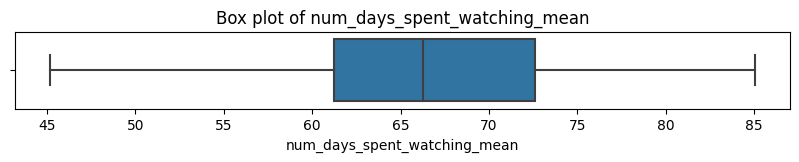

In [ ]:
print(country_num_days_spent_watching_mean_100["num_days_spent_watching_mean"].describe())

plt.figure(figsize=(10, 1))
plot = sns.boxplot(x="num_days_spent_watching_mean", data=country_num_days_spent_watching_mean_100)
title = "Box plot of num_days_spent_watching_mean"
plt.title(title)
plt.xlabel("num_days_spent_watching_mean")
plt.show()

We observe that the distribution is between 60 and 70 hours. Do people watch the same animes around the world?

In [ ]:
users_cleaned.sort_values(by="user_days_spent_watching", ascending=False)

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
25195,Kanade-chan,27699,25,4665,54,0,388,952.654595,Female,"Miyazaki (宮崎), Japan",1986-01-02 00:00:00,NaN,2007-12-25 00:00:00,2013-09-13 06:31:00,6.15,22.0,58658
8199,dumnorix98,4290713,5,5479,0,66,68,945.683333,Male,"Lloret de Mar, Spain",1998-05-19 00:00:00,NaN,2014-11-30 00:00:00,2018-01-31 07:35:40,0.00,259.0,62347
25382,edinaa,6825,3,3997,20,3,224,916.217083,Female,"Brasov, Romania",1980-09-13 00:00:00,NaN,2007-07-04 00:00:00,2018-05-07 06:51:04,6.86,1.0,58102
54489,MikeOne,330583,69,3793,1,2,308,879.438160,Male,Poland,1979-12-15 00:00:00,NaN,2010-05-19 00:00:00,2018-05-20 02:21:17,6.18,21.0,56431
52913,Shouichirou,123582,101,3931,0,0,71,854.792060,Male,"Calgary, AB, Canada",1991-01-05 00:00:00,NaN,2008-12-14 00:00:00,2018-05-16 04:07:03,7.38,160.0,57313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90431,lokokinho,3739031,0,6,0,0,0,0.501389,Male,"Bojonggede, Bogor",1989-12-01 00:00:00,NaN,2014-04-29 00:00:00,2016-09-15 04:44:00,7.83,0.0,51
34009,Jessica_Yamamori,194518,1,1,0,0,0,0.501389,Female,that place over there,1994-01-31 00:00:00,NaN,2009-06-15 00:00:00,2009-06-16 11:57:00,9.50,0.0,29
57938,So_Catholic,158317,1,1,0,0,4,0.501389,Male,Apex NC.,1993-02-22 00:00:00,NaN,2009-03-11 00:00:00,2013-12-30 09:47:00,8.00,0.0,32
61000,Me77111,158327,2,1,0,0,0,0.501389,Male,"Washougal, Washington",1991-09-04 00:00:00,NaN,2009-03-11 00:00:00,2009-07-08 21:25:00,7.67,1.0,29


In [ ]:
users_days.sort_values(by="user_days_spent_watching", ascending=False)

,user_id,user_days_spent_watching,country
7331,4290713,945.683333,Spain
22701,6825,916.217083,Romania
48634,330583,879.438160,Poland
47244,123582,854.792060,Canada
62677,5585853,815.483102,Argentina
...,...,...,...
55137,407621,0.502778,United States of America
51717,158317,0.501389,United States of America
54511,158327,0.501389,United States of America
80909,3739031,0.501389,Indonesia
